Following example here: https://github.com/open2c/pairtools/blob/master/doc/examples/scalings_example.ipynb

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker 
import matplotlib.gridspec 

import pairtools
import pairtools.lib.scaling as scaling
import bioframe

In [4]:
pairs_path = '/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz'

In [5]:
chromsizes = pd.read_csv("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/diploid_genome.chromsizes", sep="\t")
chromsizes = dict(zip(chromsizes.iloc[:, 0], chromsizes.iloc[:, 1]))


In [6]:
cis_scalings, trans_levels = scaling.compute_scaling(
                pairs_path,
                chromsizes=chromsizes,
                dist_range=(10, 1000000000), 
                n_dist_bins_decade=8,
                chunksize=int(1e7),
                #cmd_in="gzip -dc "
            )

# calculate average trans contact frequency _per directionality pair_
# convert from int to float64 to avoid overflow
avg_trans = (
    trans_levels.n_pairs.astype('float64').sum() 
    / trans_levels.n_bp2.astype('float64').sum()
)

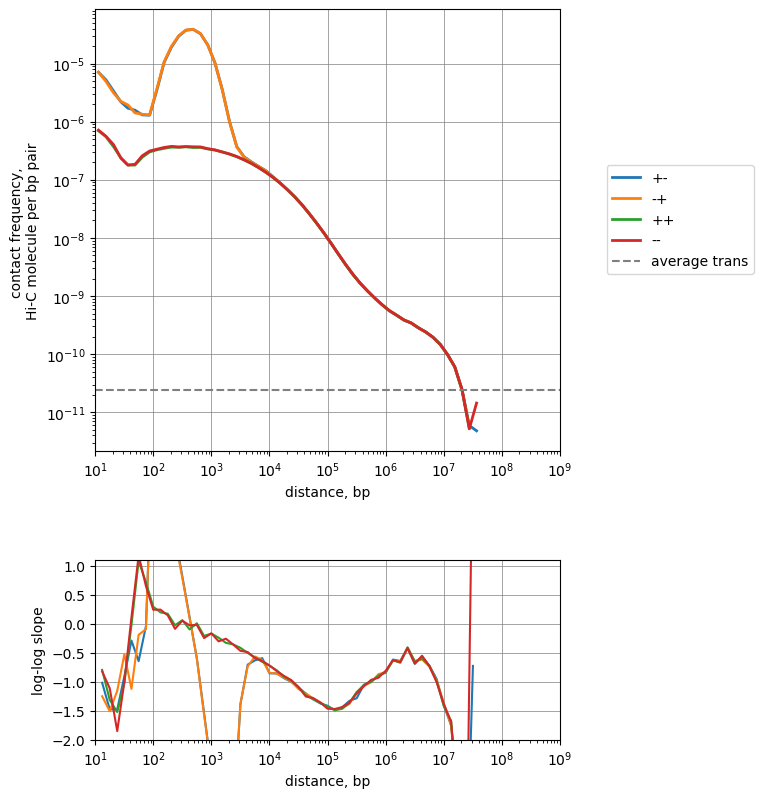

In [7]:
fig = plt.figure(figsize=(6, 10))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[8, 3])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
for strands in ['+-', '-+', '++', '--']:
    sc_strand = strand_gb.get_group(tuple(strands))
    sc_agg = (sc_strand
        .groupby(['min_dist','max_dist'])
        .agg({'n_pairs':'sum', 'n_bp2':'sum'})
        .reset_index())

    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
    mask = pair_frequencies>0
    label = f'{strands[0]}{strands[1]}'

    ax1.loglog(
        dist_bin_mids[mask],
        pair_frequencies[mask],
        label=label,
        lw=2
    )

    ax2.semilogx(
        np.sqrt(dist_bin_mids.values[1:]*dist_bin_mids.values[:-1]),
        np.diff(np.log10(pair_frequencies.values)) / np.diff(np.log10(dist_bin_mids.values)),
        label=label
    )
    
ax1.axhline(avg_trans, ls='--', c='gray', label='average trans')

plt.sca(ax1)
plt.gca().set_aspect(1.0)
plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
plt.xlim(1e1,1e9)
# plt.ylim(avg_trans / 3, plt.ylim()[1])

plt.grid(lw=0.5,color='gray')
plt.legend(loc=(1.1, 0.4))
plt.ylabel('contact frequency, \nHi-C molecule per bp pair')
plt.xlabel('distance, bp')

plt.sca(ax2)
plt.xlim(1e1, 1e9)
plt.ylim(-2, 1.1)
plt.gca().set_aspect(1.0)
plt.ylabel('log-log slope')    
plt.xlabel('distance, bp')

plt.yticks(np.arange(-2, 1.1, 0.5))
plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
plt.grid(lw=0.5, color='gray')
